# Make a software package for generating train/test data

# Add resampling, and fix all the timescales

+ Utilities for combining models / directional forcing
+ Sample at same rate
+ Easily integrate ensembles of trajectories

In [1]:
%%bash 
pip install -I .

Processing /Users/williamgilpin/program_repos/thom
  Created wheel for thom: filename=thom-0.0.0-py3-none-any.whl size=32656 sha256=63a66c05bc83aeb89c17696747e217a13df261e168251d0643aea5ab401a69a8
  Stored in directory: /private/var/folders/g_/3gcjjjc12l9cjdh8drtctrdm0000gp/T/pip-ephem-wheel-cache-c3n2k3h_/wheels/e7/a3/3b/b00bb9a6e6623759d442a2bb7ef13359cce81732ea665222f0
Successfully built thom


  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [2]:
# %reset -f

import sys

import matplotlib.pyplot as plt

from thom import *
from thom.utils import *

%load_ext autoreload
%autoreload 2

In [ ]:
1/freq_from_fft(sol[0])

In [7]:
eq = Lorenz()
sol = eq.make_trajectory(500000)
(1/freq_from_fft(sol[0])) * eq.dt

10.846880538004665

In [6]:
eq = Rossler()
print(eq.get_param_names())

sol = eq.make_trajectory(500000)
plt.plot(sol[0], sol[1])

['a', 'b', 'c']
5.85202251
38688500.0


KeyboardInterrupt: 

## Improve stochastic integration

In [30]:
@sdepy.integrate
def my_process(t, x, theta=1., k=1., sigma=1.):
    return {'dt': k*(theta - x), 'dw': sigma}

coarse_timeline = np.linspace(0, 1, 100)
timeline = np.linspace(0., 1., 500)
x = my_process(x0=1, paths=10,
               steps=100)(coarse_timeline)
x.shape

(100, 10)

## Make Lorenz Ensemble for classification

In [ ]:
def make_ensemble(model, n_samples, frac_perturb_param=.1, 
                  n_classes=2, frac_transient=0.1, ic_range=None,
                  random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.
    
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    num_per_class = int(n_samples/n_classes)

    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params
    
num_samples = 120

data, labels = generate_lorenz_ensemble(np.linspace(0, 500, 125000), 2*num_samples, (10, 28, 2.5), 
                                    n_classes=8, frac_perturb_param=.2, frac_transient=.2)


In [9]:
# def generate_lorenz_ensemble(tpts0, n_samples, params, frac_perturb_param=.1, 
#                              n_classes=2, frac_transient=0.1, 
#                              ic_range=None,
#                             random_state=0):
#     """
#     Generate an ensemble of trajectories with random initial conditions, labelled by different
#     sets of parameters.
    
#     tpts : the timesteps over which to run the simulation
#     params : iterable, the starting values for the parameters
#     n_samples : int, the number of different initial conditons
#     n_classes : int , the number of different parameters
#     frac_perturb_param : float, the amount to perturb the parameters by
#     frac_transient : float, the fraction of time for the time series to settle onto the attractor
#     ic_range : a starting value for the initial conditions
#     random_state : int, the seed for the random number generator
#     """
#     np.random.seed(random_state)
    
#     ntpts = len(tpts0)
#     dt = tpts0[1] - tpts0[0]
#     t_range = tpts0[-1] - tpts0[0]
#     tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
#     num_per_class = int(n_samples/n_classes)

#     all_params = list()
#     all_samples = list()
#     for i in range(n_classes):
    
#         params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
#         params_prime = params*params_perturb
#         all_params.append(params_prime)
    
#         eq = Lorenz(*params_prime)
        
#         all_samples_per_class = list()
#         for j in range(num_per_class):
#             ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
#             sol = integrate_dyn(eq, ic_prime, tpts)
            
#             all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
#         all_samples.append(all_samples_per_class)
    
#     all_samples, all_params = np.array(all_samples), np.array(all_params)
#     return all_samples, all_params
    
# num_samples = 120

# data, labels = generate_lorenz_ensemble(np.linspace(0, 500, 125000), 2*num_samples, (10, 28, 2.5), 
#                                     n_classes=8, frac_perturb_param=.2, frac_transient=.2)


# Sprott family

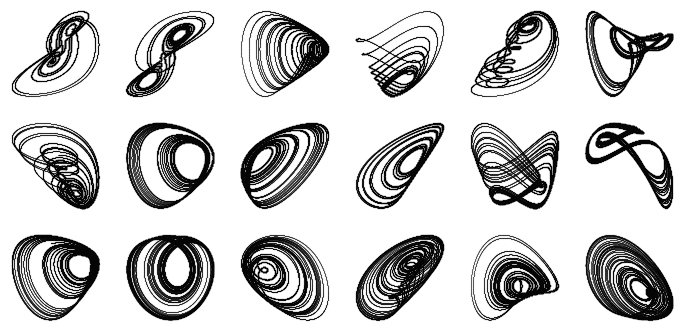

In [2]:
np.random.seed(0)
all_ensembles = list()
plt.figure(figsize=(12, 12))
for i, model in enumerate([SprottB(), SprottC(), SprottD(), SprottE(), SprottF(), SprottG(), 
              SprottH(), SprottI(), SprottJ(), SprottK(), SprottL(), SprottM(),
              SprottN(), SprottO(),SprottP(), SprottQ(), SprottR(), SprottS()]):
    
    
#     tpts = resample_timepoints(model, ic, tpts, pts_per_period=800)
    sol = model.make_trajectory(100000)
    
    plt.subplot(6, 6, i+1)
    plt.plot(sol[0], sol[1], '.k', markersize=.1)

#     ensemble = generate_ic_ensemble(model, tpts, 5, frac_perturb_param=.2)
#     all_ensembles.append(ensemble)
    
    plt.axis('off')

0 / 106
1 / 106
2 / 106
3 / 106
4 / 106
5 / 106
6 / 106


/Users/williamgilpin/program_repos/thom/thom/thom.py:313: RuntimeWarning: invalid value encountered in sqrt
  rf = (self.ci - self.z0*z)*np.sqrt(x)


7 / 106


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  h_new = (y[ind] + new_factor * y_scale[ind]) - y[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:307: RuntimeWarning: overflow encountered in multiply
  h = (y + factor * y_scale) - y
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:337: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:359: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


8 / 106
9 / 106
10 / 106
11 / 106
12 / 106
13 / 106
14 / 106
15 / 106
16 / 106
17 / 106
18 / 106
19 / 106
20 / 106
21 / 106
22 / 106
23 / 106
24 / 106
25 / 106
26 / 106
27 / 106
28 / 106
29 / 106
30 / 106
31 / 106
32 / 106
33 / 106
34 / 106
35 / 106
36 / 106
37 / 106
38 / 106
39 / 106
40 / 106
41 / 106
42 / 106
43 / 106
44 / 106
45 / 106
46 / 106


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


47 / 106
48 / 106
49 / 106
50 / 106
51 / 106
52 / 106
53 / 106
54 / 106
55 / 106
56 / 106
57 / 106
58 / 106
59 / 106
60 / 106
61 / 106
62 / 106
63 / 106
64 / 106
65 / 106
66 / 106
67 / 106
68 / 106
69 / 106
70 / 106
71 / 106
72 / 106
73 / 106
74 / 106
75 / 106
76 / 106
77 / 106
78 / 106
79 / 106
80 / 106
81 / 106
82 / 106
83 / 106
84 / 106
85 / 106
86 / 106
87 / 106
88 / 106
89 / 106
90 / 106
91 / 106
92 / 106
93 / 106
94 / 106
95 / 106
96 / 106
97 / 106
98 / 106
99 / 106
100 / 106
101 / 106
102 / 106
103 / 106
104 / 106
105 / 106
106 attractors plotted.


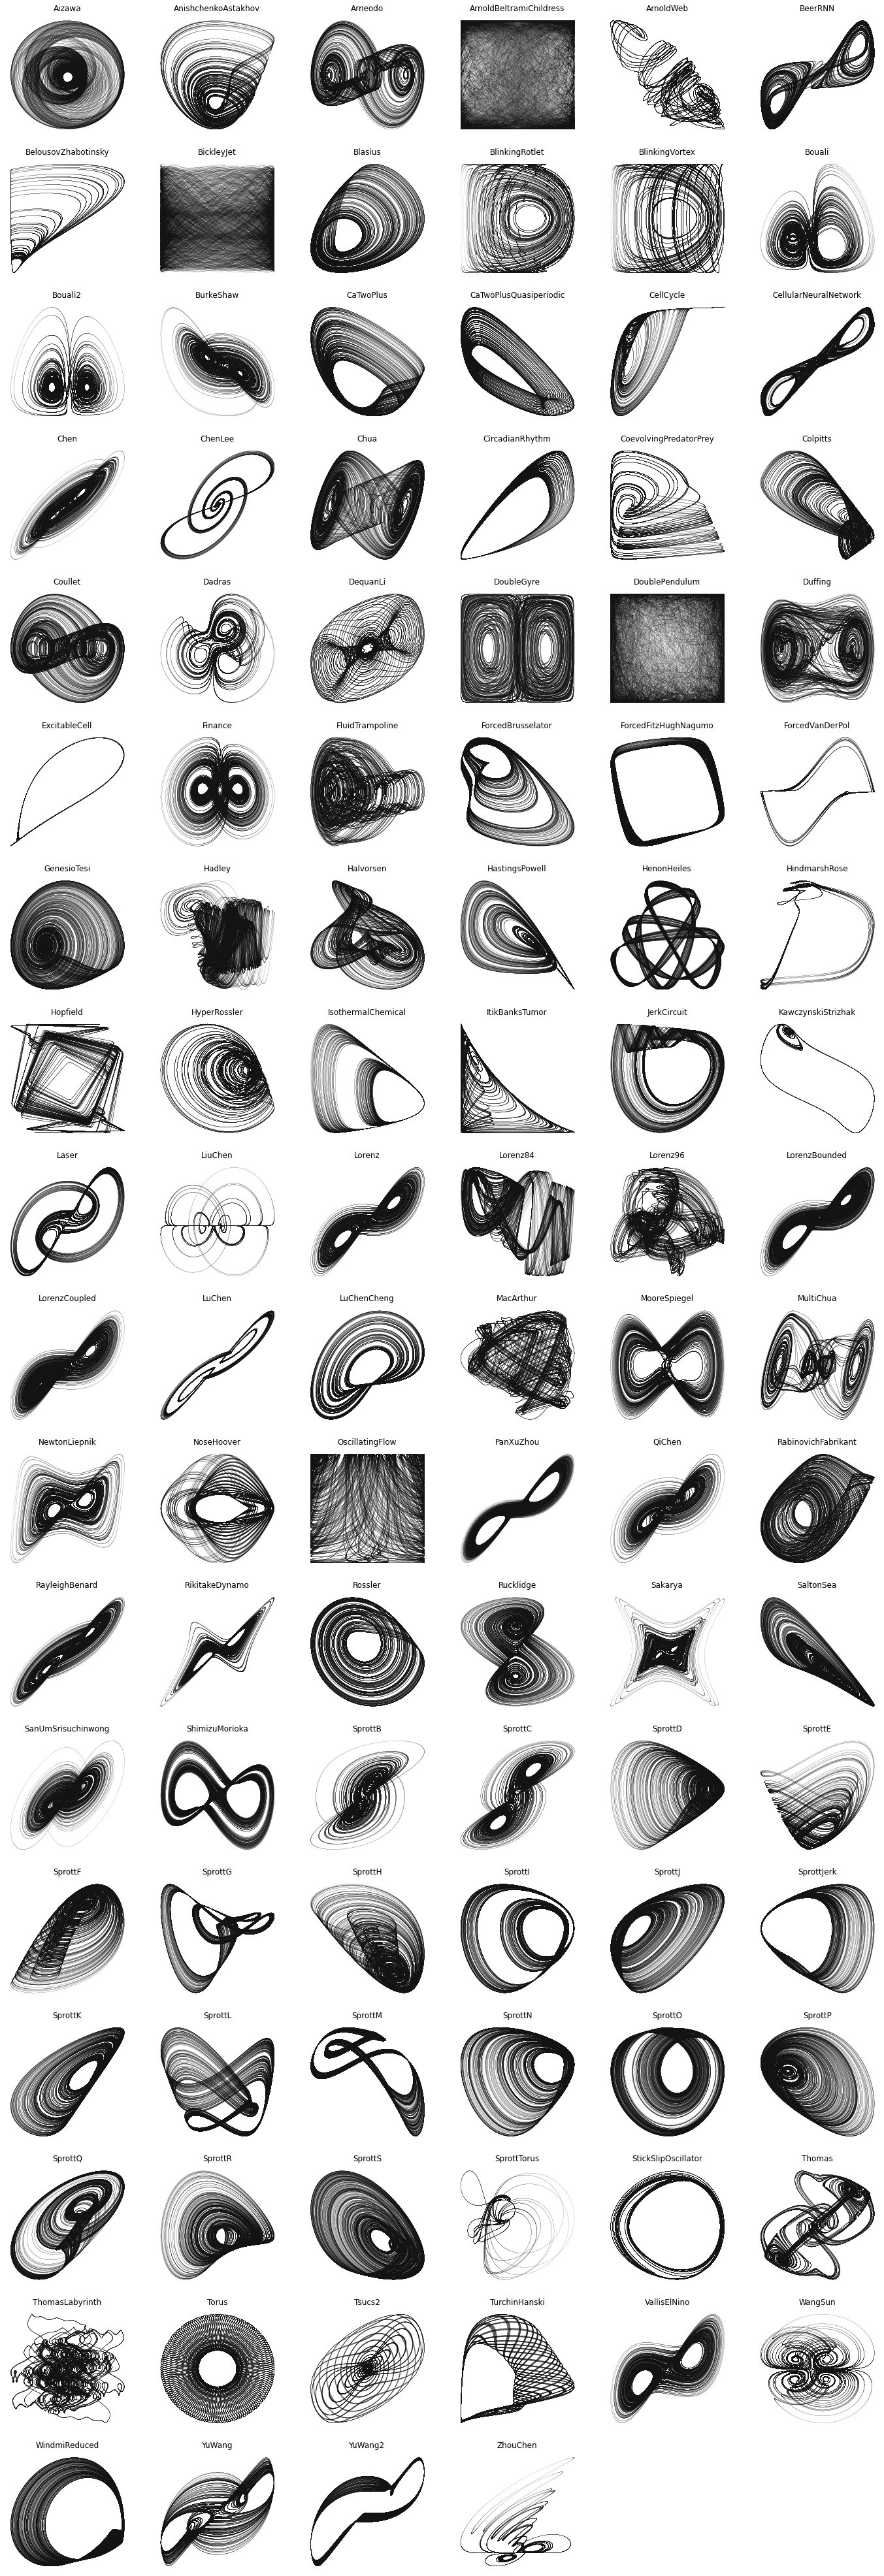

In [5]:

## Plot all attractors

all_attractors = sorted(get_attractor_list())

num_cols = 6
num_rows = int(np.ceil(len(all_attractors) / num_cols))
plt.figure(figsize=(num_cols*4, num_rows*4))
dim_counts = list()
for i, item in enumerate(all_attractors):
    if i % 1 == 0: print(i, "/", len(all_attractors))
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(1000000, method="Radau")
    dim_counts.append(len(eq.ic))
    
    # Map unbounded indices to compact interval
    if "unbounded_indices" in list(eq._load_data().keys()):
        for ind in eq._load_data()["unbounded_indices"]:
            sol[ind] = np.sin(sol[ind]) 
    
    plt.subplot(num_rows, num_cols, i+1)
    plt.plot(sol[0], sol[1], '.k', markersize=.03)
    plt.gca().title.set_text(item)
    plt.gca().axis('off')
    
print(f"{len(all_attractors)} attractors plotted.")

In [ ]:
import scipy.signal.resample


def resample_trajectory(arr, pts_per_period=100):
    n = len(arr)
    
    ## Calculate period
    1/freq_from_fft(sol[0])
    
    ## Simulate for N periods, then sample to M total points
    npts = n_periods * pts_per_period
    scipy.signal.resample(x, npts)
    

In [16]:
eq = HenonHeiles()
# eq.make_trajectory(total_length)

495.7086488245575

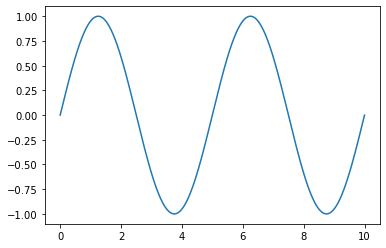

In [7]:
xx = np.linspace(0, 10, 1000)
yy = np.sin(2 * np.pi * xx / 5)

plt.plot(xx, yy)
1/freq_from_fft(yy)

In [11]:
standardize_ts(sol0.T)

NameError: name 'sol0' is not defined

In [16]:
 10/total_length

2.5e-05

[-0.7791562791136255, -0.6302244598741468, 2.671200187214492]
598950.0
0.0007077


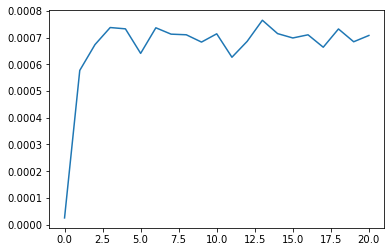

In [7]:
# Find integration timestep 

transient_fraction = .25
total_length = 40000*10
pts_per_period = 1000


eq = MultiChua()
# eq = LiuChen()
eq.dt = 10/total_length
# eq = IsothermalChemical()
# eq.dt = 1e-3


base_freq = 1 / pts_per_period
sol0 = eq.make_trajectory(total_length)
eq.ic = list(sol0[:, -1])
sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]

step_history = [np.copy(eq.dt)]

for i in range(20):
    freq = np.max(find_significant_frequencies(sol[0]))
    period = base_freq / freq
    eq.dt = eq.dt * period
    
    # prevent step from falling too low
#     if eq.dt < 10/total_length:
#         eq.dt = 10/total_length #* (1 + np.random.random())
        
    sol0 = eq.make_trajectory(total_length)
    eq.ic = list(sol0[:, -1])
    sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]
    
    step_history.append(eq.dt)
    
final_period = 1/freq_from_fft(sol[0])

print(eq.ic)
print(signif(final_period, 5))
print(signif(eq.dt, 4))


plt.plot(step_history)

In [39]:
from scipy.optimize import fsolve

def ff(x, c):
    return x - np.sin(x) - c

froot = lambda x : ff(x, 5.0)

fsolve(froot, 0.01)[0]

4.152621435127485

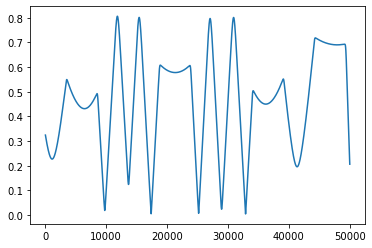

In [143]:
## Simulate a single example
eq = BlinkingVortex()
eq.dt /= 10
sol = eq.make_trajectory(500000)

# plt.plot(sol[0][-50000:], sol[2][-50000:])
# plt.plot(sol[0][-50000::])
plt.plot(sol[0][-50000:])

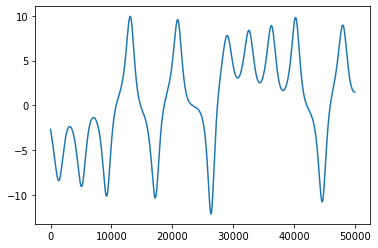

In [10]:
## Simulate a single example
eq = VallisElNino()
# eq.dt = 5e-4
sol = eq.make_trajectory(500000)

# plt.plot(sol[0][-50000:], sol[2][-50000:])
# plt.plot(sol[0][-50000::])
plt.plot(sol[0][-50000:])

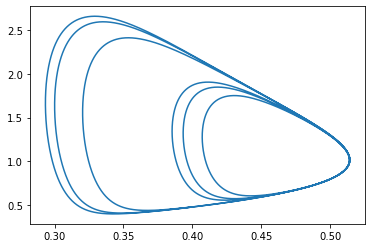

In [56]:
## Simulate a single example
eq = IsothermalChemical()
# eq.mu += 1e-3
# eq.dt = 0.01
# eq.eta = 1e-4
# eq.a = 3
sol = eq.make_trajectory(500000)

plt.plot(sol[0][-50000:], sol[1][-50000:])
# plt.plot(sol[0][-50000::])

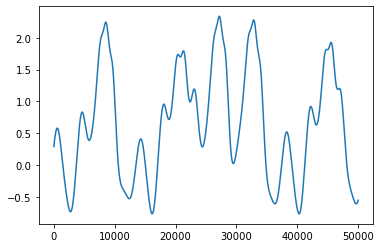

In [2]:
## Simulate a single example
eq = Lorenz84()
# eq.a *= 1.4
sol = eq.make_trajectory(500000)

# plt.plot(sol[0][-50000:], sol[1][-50000:])
plt.plot(sol[0][-50000::])

[3.14159265 1.04719755 0.4       ]
[-0.06690032  0.61267695  0.49      ]


(0.0, 3.141592653589793)

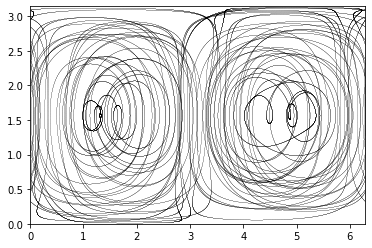

In [211]:
eq = OscillatingFlow()
eq.ic = (np.pi/4, np.pi/12, 0.4)

eq.u *= 4
eq.k /= 4
eq.b *= 4
eq.ic = np.array((np.pi/4, np.pi/12, 0.4))*np.array([4 , 4, 1])
sol = eq.make_trajectory(1000000)

print(eq.ic)
print(eq.rhs(eq.ic, 0))

plt.plot(np.mod(sol[0], 2*np.pi/eq.k), np.mod(sol[1], 2*np.pi/eq.k), '.k', markersize=.01)
plt.xlim([0, 2*np.pi/eq.k])
plt.ylim([0, np.pi/eq.k])

[3.14159265, 1.04719755, 0.4]
[-0.06690032  0.61267695  0.49      ]


(0.0, 3.141592653589793)

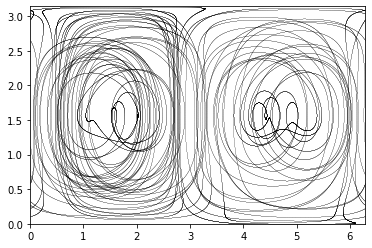

In [221]:
## Simulate a single example

eq = OscillatingFlow()
sol = eq.make_trajectory(1000000)

print(eq.ic)
print(eq.rhs(eq.ic, 0))

plt.plot(np.mod(sol[0], 2*np.pi/eq.k), np.mod(sol[1], 2*np.pi/eq.k), '.k', markersize=.01)
plt.xlim([0, 2*np.pi/eq.k])
plt.ylim([0, np.pi/eq.k])

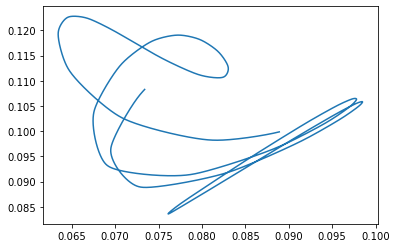

In [7]:
## Simulate a single example

sol = ArnoldWeb().make_trajectory(1000000)

# plt.plot(sol[0], sol[1], '.k', markersize=.01)

plt.plot(sol[0][-50000:], sol[1][-50000:])
# plt.plot(sol[0][-50000::])

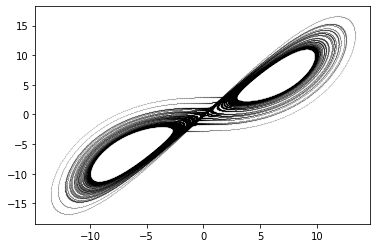

In [45]:
## Simulate a single example

sol = PanXuZhou().make_trajectory(100000)

plt.plot(sol[0], sol[1], '.k', markersize=.1)

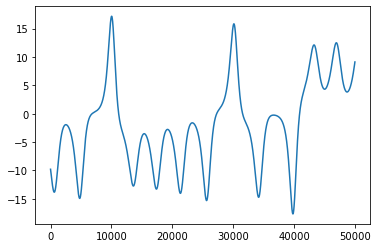

In [293]:
sol = Lorenz().make_trajectory(500000)

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[0][:50000])
# plt.plot(sol[0][:50000], sol[1][:50000])

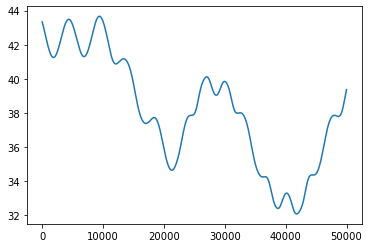

In [312]:
plt.plot(sol[0][-50000:])

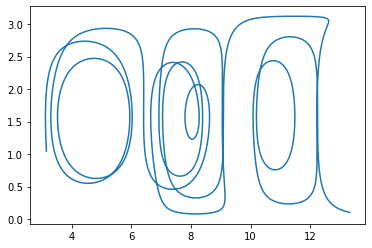

In [313]:
eq = OscillatingFlow()
eq.dt *= 1
sol = eq.make_trajectory(500000)

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
# plt.plot(sol[0][:50000])
plt.plot(sol[0][:50000], sol[1][:50000])

In [318]:
eq.a

4.5

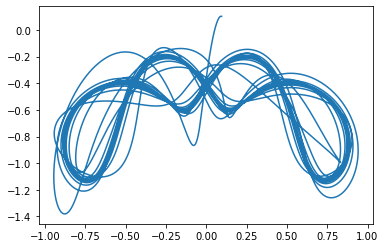

In [382]:
# plt.plot(sol[0], sol[1])
plt.plot(sol[2], sol[1])

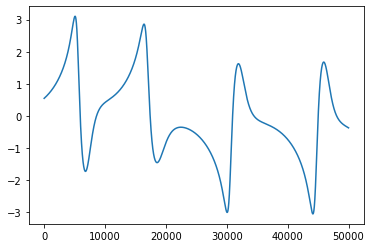

In [15]:
# eq = OscillatingFlow()

eq = Laser()
# eq = Lorenz()
# eq.dt = 0.0001432*10
# eq.f += 2
# eq.omega = 2e-1
# # eq.g *= 1
# # eq.a *=0.1
# # eq.bb *= -0.1
# # eq.d210 += 5.5
# # eq.d230 += 5.2
# # eq.sigma += 1.5
# eq.dt /= 0.1
sol = eq.make_trajectory(500000)

# plt.plot(sol[0])

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[0][-50000:])
# plt.plot(sol[0][-50000:], sol[1][-50000:])

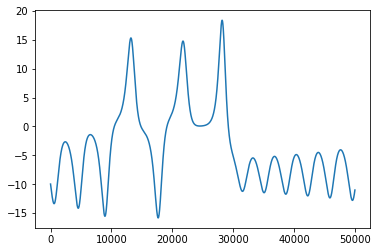

In [14]:
# eq = OscillatingFlow()

eq = Laser()
eq = Lorenz()
# eq.dt = 0.0001432*10
# eq.f += 2
# eq.omega = 2e-1
# # eq.g *= 1
# # eq.a *=0.1
# # eq.bb *= -0.1
# # eq.d210 += 5.5
# # eq.d230 += 5.2
# # eq.sigma += 1.5
# eq.dt /= 0.1
sol = eq.make_trajectory(500000)

# plt.plot(sol[0])

# plt.plot(sol[0], sol[1], '.k', markersize=.1)
plt.plot(sol[0][-50000:])
# plt.plot(sol[0][-50000:], sol[1][-50000:])

### Resample trajectories according to their period, not integration timestep

sampling_density = dt / period # Max timescale versus

[-0.6991978595902542, 2082.8170020953594]
80601.0
0.0001541


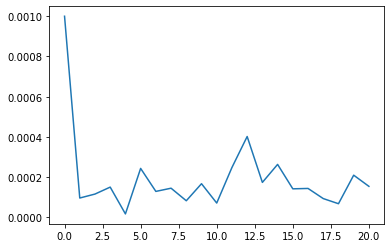

In [ ]:
0.0002226

0.0001223

In [124]:
xx = np.array([0,0,0,1])
print(eq.a[:, None]*np.cos(kk[:, None]*xx[None, :] + eq.eta[:, None]))
print(np.sum(eq.a[:, None]*np.cos(kk[:, None]*xx[None, :] + eq.eta[:, None]), axis=0))

[[-1.98782421 -1.98782421 -1.98782421 -0.8886064 ]
 [-1.98782421 -1.98782421 -1.98782421  0.62686148]
 [-0.78444226 -0.78444226 -0.78444226  0.86411484]
 [-0.69030919 -0.69030919 -0.69030919  0.03817032]]
[-5.45039988 -5.45039988 -5.45039988  0.64054024]


In [122]:
    "Laser": {
        "initial_conditions": [
            0.2499972729320594,
             0.016783121477628307,
             -0.0307487425516657,
             0.2372941902331943,
             0.04208868639291067,
             0.5658585824443308,
            0.0
        ],
        "dt": 0.01662,
        "parameters": {
            "a": 4.5,
            "g": 50,
            "omega": 0.2,
            "amp": 1.0,
            "f": 20.0,
            "bb" : 0.4,
            "sigma": 10,
            "d210" : -1,
            "d230" : 0
        },
        "citation": "TBD",
        "period": 1031.8
    },

array([-1.98782421, -1.98782421, -0.78444226, -0.69030919])

In [120]:
kk = np.arange(4) + 1
np.mean([np.sum(eq.a*np.cos(kk*item + eq.eta)) for item in [0,1,1,1]])

-0.8821947876123728

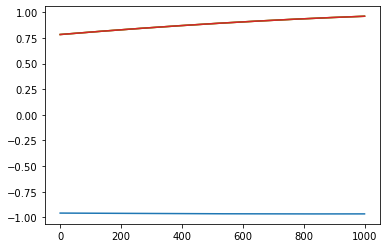

In [191]:
## Simulate a single example
eq = SymmetricKuramoto()
eq.eta = eq.eta
eq.a = .01*eq.a
sol = eq.make_trajectory(10000)

plt.plot(np.sin(sol.T)[-1000:])
# plt.plot(sol[0], sol[1], '.k', markersize=.1)

In [545]:
## Simulate a single example
eq = SymmetricKuramoto()
sol = eq.make_trajectory(10000)

plt.plot(sol.T)
# plt.plot(sol[0], sol[1], '.k', markersize=.1)

NameError: name 'SymmetricKuramoto' is not defined

In [201]:
from thom import Laser

ImportError: cannot import name 'Laser' from 'thom' (/Users/williamgilpin/program_repos/thom/thom/__init__.py)

In [4]:
## Simulate a single example
eq = Laser()
sol = eq.make_trajectory(100000)

plt.plot(sol[0][-4000:], sol[-1][-4000:])

[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]]

In [19]:
## Simulate a single example
eq = Lorenz84()
# eq.dt *= 1000
# eq.eta = 1e-4
# eq.a = 3
sol = eq.make_trajectory(100000)

plt.plot(sol[0][-4000:], sol[-1][-4000:])
# plt.plot(sol[0], sol[1], '.k', markersize=.1)

NameError: name 'Lorenz84' is not defined

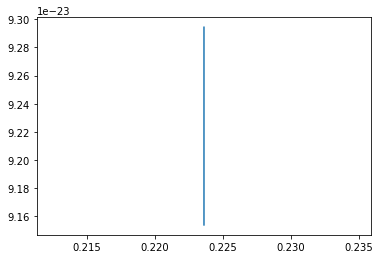

In [8]:
## Simulate a single example
eq = Laser()
eq.dt *= 1000
# eq.eta = 1e-4
# eq.a = 3
sol = eq.make_trajectory(100000)

plt.plot(sol[0][-4000:], sol[-1][-4000:])
# plt.plot(sol[0], sol[1], '.k', markersize=.1)

### Find timescales and dt and write to databse

+ Numerical integration timestep is determined by the highest significant frequency in the power spectrum
+ Initial conditions are chosen to lie on the attractor, but as close to one other as possible (align phases)
+ Certain cases: BickleyJet, StickSlipOscillator fail and require manual fine-tuning of dt

In [88]:
import json

import thom
from thom.utils import standardize_ts, find_characteristic_timescale, freq_from_autocorr, freq_from_fft, resample_timepoints, integrate_dyn, signif


with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))



# We will make a local copy of the internal database
path_output = "./chaotic_attractors.json"


all_freqs = list()
all_sols = list()

transient_fraction = .25
total_length = 40000*10

for item in list(data.keys()):
# for item in ["FluidTrampoline"]:
    
    eq = getattr(thom, item)()
    
    try:
        pts_per_period = 1000
        base_freq = 1 / pts_per_period
        sol0 = eq.make_trajectory(total_length)
        eq.ic = list(sol0[:, -1])
        sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]

        for i in range(5):
            # freq = freq_from_autocorr(sol[0])
            # freq = freq_from_fft(sol[0])
            # freq = 1/find_characteristic_timescale(sol[0])
            freq = np.max(find_significant_frequencies(sol[0]))
            period = base_freq / freq
            eq.dt = eq.dt * period # larger period needs larger timestep
            sol0 = eq.make_trajectory(total_length)
            eq.ic = list(sol0[:, -1])
            sol = standardize_ts(sol0.T).T[:, int(transient_fraction*total_length):]
            print(freq, end = " ")
        print("\n")

        all_sols.append(sol)

        freq2 = freq_from_fft(sol[0])
        all_freqs.append((freq, freq2))

        data[item]["initial_conditions"] = [signif(item, 8) for item in eq.ic]
        data[item]["dt"] = signif(eq.dt, 4)
    
    except Exception as e:
        print(e)
        pass

# Save an updated copy of the database
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

95
0.0011966666666666666 0.0010033333333333333 0.001 0.001 0.00083 



## Find and write period of each attractor
+ Expressed in units of dt

In [8]:
eq = Lorenz()
sol = eq.make_trajectory(500000)
(1/freq_from_fft(sol[0])) * eq.dt

10.846880538004665

In [30]:
sol[0]

array([ -9.7869288 ,  -9.7963878 ,  -9.80584856, ..., -11.01206907,
       -11.02037932, -11.02868408])

In [33]:
eq = Lorenz()
sol = eq.make_trajectory(1000000)
period = np.median([1/freq_from_fft(item) * eq.dt for item in sol])
period

7.882615124867241

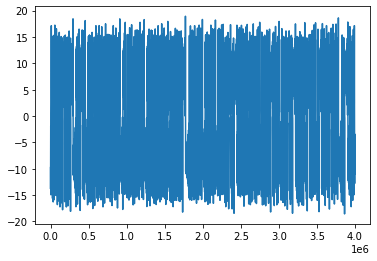

In [28]:
plt.plot(sol[0])

In [ ]:
# We will make a local copy of the internal database
path_output = "./chaotic_attractors.json"


total_length = 40000*100

with open("thom/data/chaotic_attractors.json", "r") as file:
    data = json.load(file)
print(len(data.keys()))

for item in list(data.keys()):
    
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    period = np.median([1/freq_from_fft(item) * eq.dt for item in sol])
    
    data[item]["period"] = signif(period, 5)
    print(item, " ", period)
    
with open(path_output, 'w') as f:
    json.dump(data, f, indent=4)

106
Lorenz   14.35433361192221
LorenzBounded   117.72595832442157
LorenzCoupled   69.30442660469714
Lorenz84   3002.2398228083316
Lorenz96   1180.940871619081
Thomas   6.307350912427245
ThomasLabyrinth   45.092694289941306
HenonHeiles   6.679432376124373
Chua   10.958445905686224
MultiChua   1674.7849543161851


/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: overflow encountered in exp
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)
/Users/williamgilpin/program_repos/thom/thom/thom.py:264: RuntimeWarning: invalid value encountered in double_scalars
  zdot = -z - x  - self.eps*(np.exp(y/self.y0) - 1)


JerkCircuit   9.66497041145108
Colpitts   3794.8139653682515
Duffing   21.22586588786552
Torus   3145.335059466802
Halvorsen   1771.2020195758585
MooreSpiegel   1.2192272214384288
Bouali2   141.810483726462
Bouali   12.795898660862733
Arneodo   2.662018160910647
Coullet   5.864106665089977
Rucklidge   13.251330390239238
BurkeShaw   1.2740429682429835
ZhouChen   98.25849773748233
LuChenCheng   914.6971983421067
Chen   0.5937063256821102
ChenLee   8.800831273628923
LuChen   0.7821806710405682
QiChen   0.6113252942087681


/Users/williamgilpin/program_repos/thom/thom/thom.py:697: RuntimeWarning: overflow encountered in exp
  zdot = np.exp(x*y) - self.d*z
/Users/williamgilpin/program_repos/thom/thom/thom.py:697: RuntimeWarning: invalid value encountered in double_scalars
  zdot = np.exp(x*y) - self.d*z


YuWang   0.9140182314663783


/Users/williamgilpin/program_repos/thom/thom/thom.py:705: RuntimeWarning: overflow encountered in cosh
  zdot = np.cosh(x*y) - self.d*z
/Users/williamgilpin/program_repos/thom/thom/thom.py:705: RuntimeWarning: invalid value encountered in double_scalars
  zdot = np.cosh(x*y) - self.d*z


YuWang2   1.1813752048991948
NewtonLiepnik   10.282296737757667
DequanLi   11.140322083557404
Tsucs2   0.34503527714562726
ArnoldWeb   28810.50054566368
PanXuZhou   6217.112482787981
WangSun   41.63661375330109
Sakarya   5.382025643550527
LiuChen   11.09207472387467
Aizawa   1.7950808484312346
SanUmSrisuchinwong   31.450207030570823
Finance   7.966378692834775
Dadras   1197.5162470402443
RikitakeDynamo   5795.115450180128
RabinovichFabrikant   4157.217680118757
AnishchenkoAstakhov   6415.197404384618
GenesioTesi   5.975610509792647
ShimizuMorioka   14.545028929036913


In [ ]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

for item in list(data.keys())[:10]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

## Plot attractors with matching dominant timescales

+ This does not look great, because the sub-leading timescales are clearly more important for some attractors

50
195
220
22
17
2
29
235
6
86


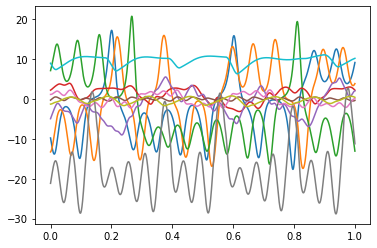

In [121]:
# Find the number of integration timepoints per period

import thom

transient_fraction = 0.1
total_length = 100000
points_per_period = 1000

all_attractors = get_attractor_list()

for item in all_attractors[:10]:
    eq = getattr(thom, item)()
    sol = eq.make_trajectory(total_length)
    
    
    freq_ceiling = np.max(find_significant_frequencies(sol[0]))
    freq_dominant = freq_from_fft(sol[0])
    
    timepoints_per_cycle = int(freq_ceiling/freq_dominant)
    print(timepoints_per_cycle)
    
    sol = eq.make_trajectory(timepoints_per_cycle*2000)
#     sol = eq.make_trajectory(50000)
    
    plt.plot(np.linspace(0, 1, len(sol[0])), sol[0])
    
#     plt.figure()
#     plt.plot(sol[0], sol[1], 'k')
    

In [13]:

from numpy.fft import rfft
from scipy.signal import blackmanharris, fftconvolve, periodogram


def surrogate_time_series(sig):
    """
    Construct a surrogate time series
    """
    


1.3333333333333333e-05

In [27]:

# insert a control function that takes the current values of all vars and adds forcing

# various functions for sampling from each system, and removing transients

# function that goes to numba

# function that couples attractors together (can use slaving to force chaos)

In [ ]:
#https://stackoverflow.com/questions/1796180/how-can-i-get-a-list-of-all-classes-within-current-module-in-python

In [ ]:
## Some day have an API working

import inspect


def generate_data(model, n_samples, params, frac_perturb_param=.1, 
                             n_classes=2, frac_transient=0.1, 
                             ic_range=None,
                            random_state=0):
    """
    Generate an ensemble of trajectories with random initial conditions, labelled by different
    sets of parameters.

    model : an instantiation of a dynamical system
    tpts : the timesteps over which to run the simulation
    params : iterable, the starting values for the parameters
    n_samples : int, the number of different initial conditons
    n_classes : int , the number of different parameters
    frac_perturb_param : float, the amount to perturb the parameters by
    frac_transient : float, the fraction of time for the time series to settle onto the attractor
    ic_range : a starting value for the initial conditions
    random_state : int, the seed for the random number generator
    """

    num_per_class = int(n_samples/n_classes)

    params = inspect.getfullargspec(model.__init__).defaults # get default values of params
    
    params = model.get_params()

    param_fractional_perturb = frac_perturb*2*(np.random(len(model.default_params)) - 0.5)
    params = model.default_params*param_fractional_perturb

    mod = model(*params)
    
    
    
    
    np.random.seed(random_state)
    
    ntpts = len(tpts0)
    dt = tpts0[1] - tpts0[0]
    t_range = tpts0[-1] - tpts0[0]
    tpts = np.arange(tpts0[0], tpts0[0] + t_range*(1 + frac_transient), dt)
    
    all_params = list()
    all_samples = list()
    for i in range(n_classes):
    
        params_perturb = 1 + frac_perturb_param*(2*np.random.random(len(params)) - 1)
        params_prime = params*params_perturb
        all_params.append(params_prime)
    
        eq = Lorenz(*params_prime)
        
        all_samples_per_class = list()
        for j in range(num_per_class):
            ic_prime = (-8.60632853, -14.85273055,  15.53352487)*np.random.random(3)
            sol = integrate_dyn(eq, ic_prime, tpts)
            
            all_samples_per_class.append(sol[:, -ntpts:]) # remove transient
        all_samples.append(all_samples_per_class)
    
    all_samples, all_params = np.array(all_samples), np.array(all_params)
    return all_samples, all_params